In [1]:
!pip install torch


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as trans
from torchvision.datasets import MNIST

In [3]:
!pip install timm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import timm
import matplotlib.pyplot as plt
import math

In [6]:
class NumbersDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [7]:
class NumberClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        out_size = 1280
        self.classifier = nn.Linear(out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [8]:
model = NumberClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
transform = trans.Compose([
    trans.Resize(224),
    trans.Grayscale(num_output_channels=3),
    trans.ToTensor()
])

train_dataset = NumbersDataset(
    data=MNIST(root='./data', train=True, download=True, transform=transform),
)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset = NumbersDataset(
    data=MNIST(root='./data', train=False, download=True, transform=transform),
)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [10]:
crit = nn.CrossEntropyLoss()  # loss-func
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epoch = 7
train_losses = []

# P.S. ограничил выборку для обучения и теста до 1000 изображений(для быстрой демонстрации)

In [11]:
for epoch in range(num_epoch):
    model.train()
    total_loss = 0.0
    i = 0

    for image, label in train_dataloader:
        if i == 100:
            break

        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = crit(outputs, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        i += 1

    train_loss = total_loss / len(train_dataloader)
    train_losses.append(train_loss)

    print(f"current epoch: {epoch+1}; current loss: {train_loss}")

current epoch: 1; current loss: 0.0110165515349557
current epoch: 2; current loss: 0.004474517163199683
current epoch: 3; current loss: 0.003740366264556845
current epoch: 4; current loss: 0.0025028361146493504
current epoch: 5; current loss: 0.0030177996035975715
current epoch: 6; current loss: 0.0024390941152814777
current epoch: 7; current loss: 0.002463744488894008


In [12]:
model.eval()
correct = 0
total = 0

In [13]:
with torch.no_grad():
    i = 0

    for image, label in test_dataloader:
        if i == 100:
            break

        image = image.to(device)
        label = label.to(device)

        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        i += 1

accuracy = 100 * correct / total
print(f"final accuracy: {round(accuracy, 2)}")

final accuracy: 98.1


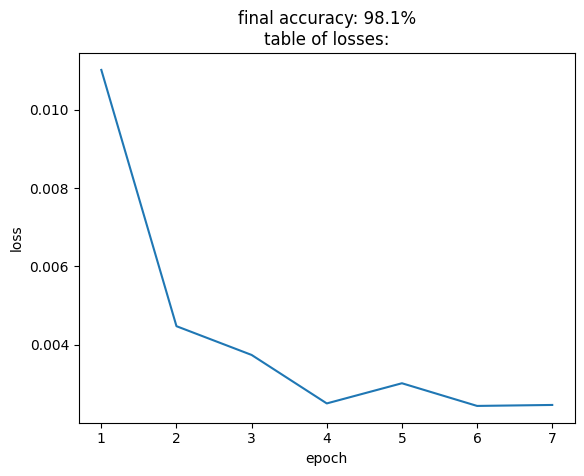

In [14]:
plt.plot([1, 2, 3, 4, 5, 6, 7], train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"final accuracy: {round(accuracy, 2)}%\ntable of losses:")
plt.show()